# Philo: Cold Gas VTVL Rocket - Design Notebook
-------------------------------------------------------------
Philo is a small-scale cold gas VTVL rocket

By: Ara Kourchians

In [31]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


The goal of this notebook is to outline the process for designing the a cold gas rocket. Throughout this process, it's important to keep in mind that the values we generate have to be reasonable. Meaning, our results must be realistic when it comes to machining, sensing, and controlling. Once we obtain these rough numbers, we can evaluate and tune them to match existing COTS, and if necessary fabricate custom parts.

Before we dive in, we must first state our assumptions and initial parameters. The assumptions allow us to simplify the model, while the initial parameters give us a starting point to work from.


### Assumptions:
1. Processes within the engine are isentropic
2. Flow is choked at the throat of the nozzle where Ma = 1
3. Pb = 101.325kPa (Ambient Pressure)
4. Tb = 298.15K (Ambient Temperature)
5. Propellant acts as an ideal gas (later, we will model it as a real gas)

### Initial Vehicle Model:
1. Propellant:       Dry Air, cp = 1.005, cv = 0.718, gamma = 1.4
2. Dry mass        = 1.89kg
3. Propellant mass = 0.53kg

In [32]:
# Environment Properties
p_atm = 101325           # Pa (Ambient Pressure)
t_atm = 298.15           # K (Ambient Temperature)
t_o = 298.15             # K (Tank Temperature)
R = 8.314                # J/(K*mol)
g = 9.81                 # m/s^2

# Propellant Properties 
cp = 1.005               # Constant pressure specific heat
cv = 0.718               # Constant volume specific heat
molar_mass = 0.02897     # kg/mol
gamma = cp/cv            # Specific Heat Ratio

# Tank Properties
tank_volume = 0.00147484            # m^3

# Regulator Properties
p_reg_min = 2.068e6                 # Pa

# Vehicle Properties
dry_mass = 1.89                     # kg (rough estimation based on current design)
prop_mass = 0.53                    # kg (based on tank capacity and gas)
wet_mass = dry_mass + prop_mass     # kg

### Approach:

> <b>Understand the Basics</b>

> Step 1: Theoretical Flight Time

> Step 2: Critical Properties

> <b>Calculate Parameters for a Minimal/Simple Design (Ma = 1)</b>

> Step 3: Velocity at the Exit

> Step 4: Cross-Sectional Area at the Exit of the Nozzle

> Step 5: Flight Time

> <b>Calculate Parameters for an Optimized Design (Ma > 1)</b>

> Step 6: Optimize Time of Flight by sweeping Nominal Chamber Pressure

> Step 7: Cross-Sectional Area at the Throat

> <b>Accurately Model Propellant and Tank</b>

> Step 8: Model Propellant as a Real Gas

> Step 9: Recalculate Vehicle and Engine Parameters

#### Step 1: Determine Theoretical Flight Time

With our initial assumptions and vehicle model, we can determine the theoretical maximum flight time using the rocket equation to solve for delta_V and dividing it by the gravity vector to obtain flight time:

\begin{equation}
V_\Delta = V_e * ln\left(\frac{m_o}{m_f} \right) \tag{1} 
\end{equation}

Where V_e_expected = ~1000m/s   (Based on Figure 2-5 of "Rocket Propulsion Elements")

In [33]:
v_e_expected = 1000   # m/s (APPROXIMATION, SOURCE R.P.E.)

delta_v = v_e_expected * np.log(wet_mass/dry_mass)

print ("Delta V: %0.2f m/s" % delta_v)

Delta V: 247.19 m/s


Divide by the gravity vector to obtain flight time:

In [34]:
t_theoretical = delta_v / g

print ("Theoretical Flight Time: %0.2f sec" % t_theoretical)

Theoretical Flight Time: 25.20 sec



#### Step 2: Critical Properties
In order to solve for the critical properties of our engine, we must first define the following variables and make note of the following key concepts regarding nozzles and choked flow.

Variables:

> * P = Pressure (Pa)
> * P_o = Stagnation (total) Pressure = Dynamic Pressure + Static Pressure
> * T = Temperature (K)
> * T_o = Stagnation Temperature
> * V = Velocity (m/s)
> * A = Area (m^2)
> * Rho = Density (kg/m^3)
> * Ma = Mach Number 
> * c = Speed of sound in the medium (m/s)

Key Concepts:

> * The critical properties and critical ratios (Eqs 4, 5, and 6) are a direct function of the propellant properties as well as the pressure differential between the chamber and exit.

> * A converging section of the nozzle is required to bring subsonic flow to sonic flow.

> * A diverging section of the nozzle, following the throat (minimum area), is required to bring the sonic flow to supersonic flow.

<img src="subsonic_flow.png" style="max-width:100%; width: 75%">
<img src="supersonic_flow.png" style="max-width:100%; width: 75%">

> * Choked flow occurs when the stagnation properties (P_o & T_o) are greater than or equal to the product of the exhaust properties (P_b & T_b) and they're respective critical ratios. Essentially, at some point the pressure on one side of a hole will be so great that the gas can not escape at any greater rate.

> * At choked flow, mass flow rate is <b>constant</b>.

For more information on critical properties and choked flow, refer to "Thermodynamics: An Engineering Approach", Chapter 17: Compressible Flow.

To better understand why we must have a converging diverging nozzle, we plot the area ratio equation (Eq 3), derived from equations 2, 5, 6, and 10. 

\begin{equation}
\rho A V = constant = \rho^* A^* V^* \tag{2}
\end{equation}

\begin{equation}
\frac{A}{A_*} = \frac{1}{Ma}\left[ \frac{1+\frac{\gamma-1}{2}Ma^2}{1+\frac{\gamma-1}{2}} \right]^\frac{\gamma+1}{2(\gamma-1)} \tag{3} 
\end{equation}

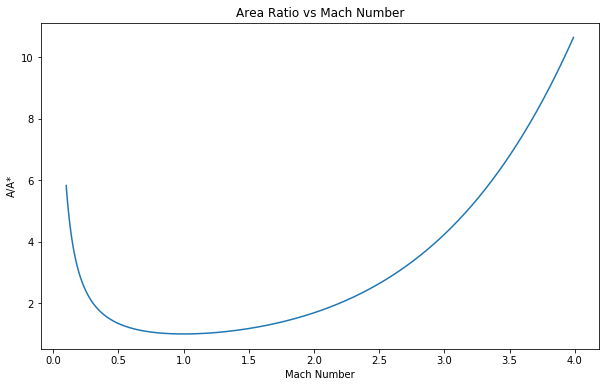

In [35]:
def area_ratio(ma):
    
    a_ratio = (1/ma)*(((1+((gamma-1)/2)*(ma**2))/(1+((gamma-1)/2)))**((gamma+1)/(2*(gamma-1))))
    
    return a_ratio

ma_array = np.arange(0.1, 4, 0.01)
a_array = area_ratio(ma_array)

plt.figure(1,figsize=(10,6))
plt.xlabel('Mach Number')
plt.ylabel('A/A*')
plt.title('Area Ratio vs Mach Number')
plt.plot(ma_array, a_array)
plt.show()

Notice how the ratio decreases as the Mach number increases. The ratio then reaches a minimum when the mach number is equal to 1, where by after, the ratio begins to increase again. This tells us that a coverging and diverging section of the nozzle are require to achieve supersonic exit velocities. We need to keep this in mind as we're going to need at step 6, but until then, we will calculate the minimum set of conditions required for choked flow assuming our "Simple" engine model.

Next we calculate the critical ratios:

\begin{equation}
\frac{P_o}{P} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{\gamma}{\gamma-1} \tag{4} 
\end{equation}

\begin{equation}
\frac{T_o}{T} = 1+\left(\frac{\gamma-1}{2}\right)Ma^2 \tag{5} 
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho} = \left[1+\left(\frac{\gamma-1}{2}\right)Ma^2\right]^\frac{1}{\gamma-1} \tag{6} 
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left(\left(\frac{P_o}{P}\right)^{\frac{\gamma-1}{\gamma}} - 1\right)} \tag{7} 
\end{equation}

To calculate the critical properties:

\begin{equation}
\frac{P_o}{P_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_*} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_*} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

Since our back pressure is fixed to 101.325kPa (1atm), we need to work back what the minimum required chamber pressure would be in order to achieve choked flow:

\begin{equation}
\frac{P_o}{P_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{\gamma}{\gamma-1}
\end{equation}

\begin{equation}
\frac{T_o}{T_b} = 1+\left(\frac{\gamma-1}{2}\right)
\end{equation}

\begin{equation}
\frac{\rho_o}{\rho_b} = \left[1+\left(\frac{\gamma-1}{2}\right)\right]^\frac{1}{\gamma-1}
\end{equation}

In [36]:
# Calculate Minimum Chamber Properties

ma_t = 1.0     # Minimum mach number required to achieve choked flow is 1
p_b = p_atm    # Back pressure is pressure at sea level

p_o = p_b*(((1+((gamma-1)/2)*(ma_t**2))**(gamma/(gamma-1))))
t_b = t_o/(1+(((gamma-1)/2)*(ma_t)))

p_o_critical = p_o

print ("Choked Flow:")
print ("Ma_t: %.2f" % ma_t)
print ("Given Exit/Throat Pressure: %.2f Pa" % p_b)
print ("Calculated Minimum Chamber Pressure (Critical Pressure): %.2f Pa" % p_o)
print ("Given Chamber Temperature: %.2f K" % t_o)
print ("Calculated Exit/Throat Temperature: %.2f K" % t_b)

Choked Flow:
Ma_t: 1.00
Given Exit/Throat Pressure: 101325.00 Pa
Calculated Minimum Chamber Pressure (Critical Pressure): 191784.01 Pa
Given Chamber Temperature: 298.15 K
Calculated Exit/Throat Temperature: 248.49 K


#### Step 3: Determine Velocity at the Exit

Before we continue, we're going to temporarly model our engine as simple converging-only nozzle:
<br><br>
<img src="converge_only_nozzle.png" style="max-width:100%; width: 50%">
<br>

Now that we know the minimum chamber pressure for choked flow, we can calculate the expected exit velocity at the exit (V_th) using the following equation:

Where c is the sound velocity:

\begin{equation}
c = \sqrt{\frac{\gamma R T}{m_{molar}}} \tag{8} 
\end{equation}

\begin{equation}
M_a = \sqrt{\frac{2}{\gamma-1}\left( \left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}} - 1 \right)} \tag{9} 
\end{equation}

\begin{equation}
V = M_ac \tag{10} 
\end{equation}

When combined becomes:

\begin{equation}
V = \sqrt{\frac{T_b R}{m_{molar}}*\frac{2 \gamma}{\gamma-1}*\left(\left(\frac{P_o}{P_b}\right)^{\frac{\gamma-1}{\gamma}}-1\right)} \tag{11} 
\end{equation}

In [37]:
v_th = np.sqrt(((t_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((p_o / p_b) ** (
        (gamma - 1) / gamma)) -1 )

isp = v_th / g

print ("Velocity at throat: %.2f m/s" % v_th)
print ("Specific Impulse (throat only): %2f sec" % isp)

Velocity at throat: 774.11 m/s
Specific Impulse (throat only): 78.910697 sec


#### Step 4: Determine Cross-Sectional Area at the Exit of the Nozzle

Next we must solve for the cross-sectional area at the exit of the nozzle. However, before we do this, we must select our desired nominal thrust then solve for the mass flow rate using the following equation:

\begin{equation} 
F = \dot{m}*V_e + A_e(P_e - P_{atm})
\end{equation} 

\begin{equation}
F = \dot{m}*V_{th}
\end{equation}

Rewritten as:

\begin{equation}
\dot{m} = \frac{F}{V_{th}} \tag{12} 
\end{equation}

In order to determine the desired nominal thrust, we calcuate the necessary force to null out the acceleration of a hovering/fully-loaded rocket:

\begin{equation}
F_{nominal} = m_{wet} * g \tag{13} 
\end{equation}

Of course, this force will change as the vehicle loses mass, but it gives us a place to start. Compensation for loss of mass will be calculated later in this notebook.

In [38]:
f_nom = wet_mass * g

print ("Nominal Engine Thrust: %.2f N" % f_nom)

Nominal Engine Thrust: 23.74 N


With a nominal thrust, we can now work out the mass flow rate:

In [39]:
mass_flow = f_nom / v_th         # kg/s

print ("Mass Flow Rate: %.6f kg/s" % mass_flow)

Mass Flow Rate: 0.030668 kg/s


Using the mass flow rate, we finally determine the cross-sectional area at the exit using the following equation:

\begin{equation}
A_e = \frac{\dot{m}* \frac{R T_e}{m_{molar}} }{V_e P_e} \tag{14} 
\end{equation}

To solve for A_e we must substitute P_e (Eq 4), T_e (Eq 6), and V_e (Eq 11):

\begin{equation}
A_e = \frac{\dot{m}* \left(1+(\gamma-1)\frac{Ma_e^2}{2}\right)^\frac{\gamma+1}{2(\gamma-1)}}{Ma_e P_o\sqrt{\frac{\gamma * m_{molar}}{R T_o}}}
\end{equation}

Remember, we're starting off with a simple converging nozzle only, thus exit mach number is 1: \begin{equation} M_a = 1 \end{equation}

In [40]:
p_e = p_b
t_e = t_b

a_e = (mass_flow*(1+(gamma-1)*((ma_t**2)/2))**((gamma+1)/(2*(gamma-1))))/(ma_t*p_o*np.sqrt((molar_mass*gamma)/(R*t_o)))

print ("Cross-sectional Area at Exit: %.8f m^2" % a_e)
print ("Cross-sectional Area at Exit: %.2f mm^2" % (a_e*1e6))

print ("Exit Diameter: %.2f mm" % (2*(np.sqrt((a_e*1e6)/np.pi))) )

Cross-sectional Area at Exit: 0.00006832 m^2
Cross-sectional Area at Exit: 68.32 mm^2
Exit Diameter: 9.33 mm


#### Step 5: Determine Flight Time

We can now estimate the time of flight by dividing the total propellant mass by mass flow rate:

\begin{equation}
t_{flight} = \frac{m_{prop}}{\dot{m}} \tag{15} 
\end{equation}

It's important to note that this is an approximation and that this model does not compensate for thrust adjustments. Based on this model, the vehicle would simply begin to accelerate as it loses mass since the thrust is fixed. Later, to get an accurate time of flight, we will approch the problem numerically by solving for a new desired thrust each time step.

In [41]:
t_flight = prop_mass / mass_flow    # sec

print ("Time of Flight: %0.2f sec" % t_flight)

Time of Flight: 17.28 sec


#### Step 6: Optimize Time of Flight by sweeping Nominal Chamber Pressure

Now that we know the minimum chamber pressure, cross-sectional area at the exit of the nozzle, and the exit velocity required to null out the vehicles gravity vector, we can now sweep the chamber pressure to find optimimal vehicle parameters for maximizing time of flight.
<br><br>
<b> IMPORTANT: From this point forward, we're going to be increasing the chamber pressure. This means we'll be able to achieve exit velocities greater than mach 1, but not without redesigning our engine to have both a converging and diverging section.

Note: if we kept our simple converging-only nozzle and continued to increase the chamber pressure the exit velocity would still remain at mach 1 since the exit is undergoing choked flow. Figure 17-16 in "Thermodynamics: An Engineering Approach." does a great job illustrating this.</b>
<br><br>
<img src="converge_diverge_nozzle.png" style="max-width:100%; width: 50%">

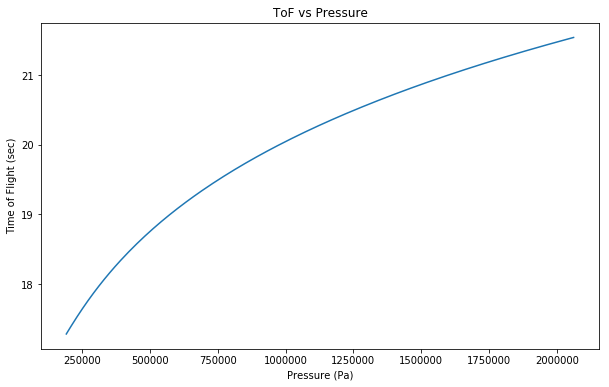

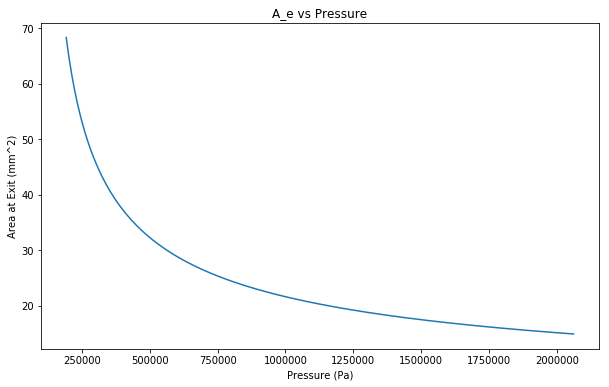

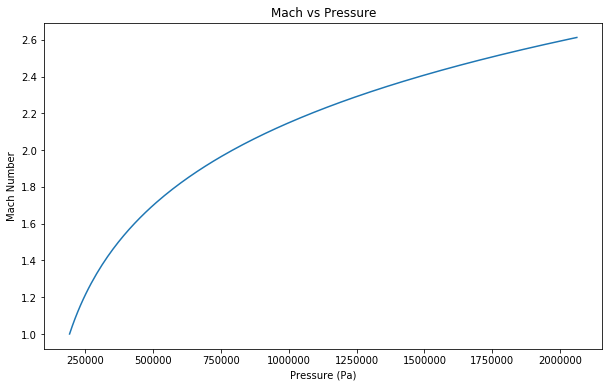

In [42]:
# Functions for previously defined equations
def calc_tank_pressure(prop_mass, molar_mass, tank_t, tank_v):
    tank_p = ((prop_mass/molar_mass)*R*tank_t)/tank_v
    return tank_p                       # Pa

def calc_mach(p_o, p_b, gamma):
    ma_e = np.sqrt((2 / (gamma - 1)) \
      * (((p_o / p_b) ** (           \
        (gamma - 1) / gamma))-1))  
    return ma_e                         # mach
    
    
def calc_t_b(t_o, ma_e, gamma):
    t_b = t_o/(1+(((gamma-1)/2)*(ma_e)))
    return t_b                          # K

def calc_v_e(p_o, p_b, t_b, molar_mass, gamma):
    v_e = np.sqrt(((t_b * R) / molar_mass) \
      * ((2 * gamma) / (gamma - 1)) \
      * ((p_o / p_b) ** (       \
        (gamma - 1) / gamma))-1)        
    return v_e                          # m/s

def calc_isp(v_e):
    isp = v_e / g
    return isp                          # sec

def calc_f_nom(wet_mass):
    f_nom = wet_mass * g
    return f_nom                        # N

def calc_mass_flow(f_nom, v_e):
    mass_flow = f_nom / v_e              
    return mass_flow                    # kg/s 

def calc_area_exit(p_o, t_o, ma_e, mass_flow, molar_mass, gamma):
    a_e = (mass_flow*(1+(gamma-1)*((ma_e**2)/2))**((gamma+1)/(2*(gamma-1))))/(ma_e*p_o*np.sqrt((molar_mass*gamma)/(R*t_o)))
    return a_e                          # m^2

def calc_time_of_flight(prop_mass, mass_flow):
    t_flight = prop_mass / mass_flow    
    return t_flight                     # sec

# Time of Flight vs Chamber Pressure
# Note: We assume constant thrust for simplcity (compensated later in step 9 for greater accuracy)
def calc_engine_params(p_o):
    ma_e = calc_mach(p_o, p_b, gamma)
    t_b = calc_t_b(t_o, ma_e, gamma)
    v_e = calc_v_e(p_o, p_b, t_b, molar_mass, gamma)
    isp = calc_isp(v_e)
    f_nom = calc_f_nom(wet_mass)
    mass_flow = calc_mass_flow(f_nom, v_e)
    a_e = calc_area_exit(p_o, t_o, ma_e, mass_flow, molar_mass, gamma)
    t_flight = calc_time_of_flight(prop_mass, mass_flow)
    
    return t_flight, a_e, ma_e

# p_o_min calculated above
p_step = 10000
p_o_min = p_o_critical  # Minimum pressure for choked flow state

# Sweep the pressure and plot the time of flight
p_array = np.arange(int(p_o_min), int(p_reg_min), p_step)
tof_array, ae_array, mae_array = calc_engine_params(p_array)
ae_array *= 1e6     # Convert from m^2 to mm^2

plt.figure(2,figsize=(10,6))
plt.xlabel('Pressure (Pa)')
plt.ylabel('Time of Flight (sec)')
plt.title('ToF vs Pressure')
plt.plot(p_array, tof_array)
plt.show()

plt.figure(3,figsize=(10,6))
plt.xlabel('Pressure (Pa)')
plt.ylabel('Area at Exit (mm^2)')
plt.title('A_e vs Pressure')
plt.plot(p_array, ae_array)
plt.show()

plt.figure(4,figsize=(10,6))
plt.xlabel('Pressure (Pa)')
plt.ylabel('Mach Number')
plt.title('Mach vs Pressure')
plt.plot(p_array, mae_array)
plt.show()


<b>Analysis:</b>

> Observations:
> - As pressure increases, time of flight increases
> - At lower pressures, we observe larger variations in time of flight
> - At higher pressures, we observe smaller variations in time of flight
> - From min to max chamber pressure, time of flight varies by 4 seconds
> <br>

> What we know about higher pressures:
> - Higher pressures require smaller fabrication tolerances (smaller cross-sectional areas, etc)
> - Higher pressures require heavier plumbing
> - Controlling higher pressures requires greater power (this becomes very more problematic as actuator bandwidth increases)
> <br>

>As expected, we asymptote near a theoretical time of flight around 25 seconds.

>Why is this value not exactly 25 seconds? <br>
Because we initially guessed an exit velocity of 1000 m/s based on a reference table. Our results reflect the expected time of flight based on the vehicle model, which is more accurate. The take away here is that our theoretical values are in-family with our model-based simulation.



<b>Selecting a nominal chamber pressure:</b>
> Based on these results, we must now select a nominal chamber pressure.
> - The pressure we select must be greater than the minimum chamber pressure required to achieve choked flow, but below the regulators maximum pressure
> - We don't want to select a pressure too close to the minimum chamber pressure  since we may break choked flow during throttle down when landing. The idea is to have plenty of pressure margin both ways.
> - Ideally, the pressure we select would be easy and cost-effictive to sense. Generally speaking, sensor mass, size, and cost increase with pressure.
> - We must select a pressure that doesn't require machining very small cross-sectional areas
> - For benchtop testing, we'd like to select a pressure that is easily generated using off-the-shelf compressors.

<b>Selected nominal chamber pressure: 500,000pa (~70psi)</b>

Now we calculate the engine parameters based on our newly selected chamber pressure:

In [43]:
p_chamber = 5e5 # Pa (~70psi), this value assumes the needle valve regulates 300psi (bottle reg) down to 70psi

tof, a_e, ma_e = calc_engine_params(p_chamber)

print ("Selected Chamber Pressure: %.2f Pa" % p_chamber)
print ("Calculated ToF: %0.2f sec" % tof)
print ("Calculated A_e: %0.8f m^2" % a_e)
print ("Calculated A_e: %.2f mm^2" % (a_e*1e6))
print ("Calculated Exit Diameter: %.2f mm" % (2*(np.sqrt((a_e*1e6)/np.pi))) )

Selected Chamber Pressure: 500000.00 Pa
Calculated ToF: 18.75 sec
Calculated A_e: 0.00003230 m^2
Calculated A_e: 32.30 mm^2
Calculated Exit Diameter: 6.41 mm


#### Step 7: Determine Cross-Sectional Area at the Throat

Up until step 6, we'd been assuming a converging-only nozzle design where we only have an exit. The next step is to add a diverging section to the nozzle in order to achieve exit velocities greater than mach 1. 

Since we calculated the cross-sectional area at the exit of the nozzle, we can calculate the required cross-sectional area at the throat to achieve a given exit velocity greater than mach 1.

\begin{equation}
\frac{A_e}{A_t} = \frac{1}{M_e}\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{\gamma+1}{2(\gamma-1)} \tag{16} 
\end{equation}

Since we already know A_e, we can now solve for A_t:

\begin{equation}
A_t = A_e M_e\left[ \left(\frac{2}{\gamma+1}\right)\left(1 + \frac{\gamma-1}{2}M_e^2\right) \right]^\frac{-\gamma+1}{2(\gamma-1)}
\end{equation}

In [44]:
print ("Exit Mach: %.2f\n" % ma_e)

a_t = (a_e*ma_e)*(((2/(gamma+1))*(1+((gamma-1)/2)*(ma_e**2)))**((-(gamma+1))/(2*(gamma-1))))

print ("Area at Throat: %0.8f m^2" % a_t)
print ("Area at Throat: %.2f mm^2" % (a_t*1e6))
print ("Throat Diameter: %.2f mm \n" % (2*(np.sqrt((a_t*1e6)/np.pi))) )

print ("Area at Exit: %0.8f m^2" % a_e)
print ("Area at Exit: %.2f mm^2" % (a_e*1e6))
print ("Exit Diameter: %.2f mm \n" % (2*(np.sqrt((a_e*1e6)/np.pi))) )

# Ae/At Ratio
a_e_a_t = a_e / a_t
print ("Ae/At Ratio: %0.2f" % a_e_a_t)

Exit Mach: 1.70

Area at Throat: 0.00002415 m^2
Area at Throat: 24.15 mm^2
Throat Diameter: 5.54 mm 

Area at Exit: 0.00003230 m^2
Area at Exit: 32.30 mm^2
Exit Diameter: 6.41 mm 

Ae/At Ratio: 1.34


<b>Step 8: Model Propellant as a Real Gas</b>

<img src="tank_blowdown.png" style="max-width:100%; width: 50%">

Now we come to a step where must model the propellant as a real gas rather than an ideal. This is because the tank loses large amounts of pressure in short amounts of time, and as a result, extra internal energy (temperature) must be converted into work in order to overcome the intermolecular forces within the gas itself. This non-ideal behavior is the Joule-Thompson Effect.

<b>Note:</b> The temperature drop under slower circumstances would be compensated by energy absorption from surrounding air. However, for our case, the temperature drop is not only very quick, but due to the poor thermal conductivity between the tank and the surrounding air, the system is unable to pull energy fast enough to compensate and equalize.

Thus to correctly model phenomenon, we must consider the worst case senario where the tank blowdown occurs adiabatically and the propellant acts as a real gas. We can model this by using the equation which describes Joule-Thompson Effect:
\begin{equation}
\frac{P_i}{P_f} = \left(\frac{T_i}{T_f}\right)^\left(\frac{\gamma}{\gamma-1}\right)
\end{equation}

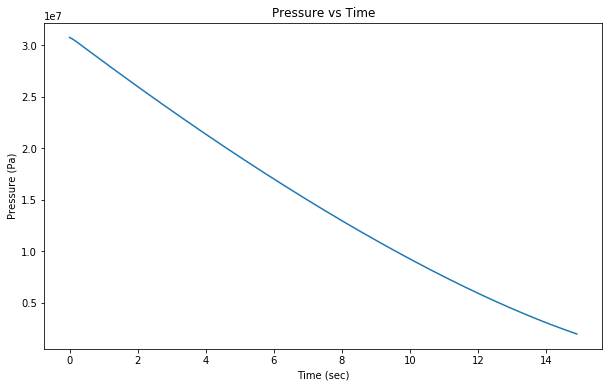

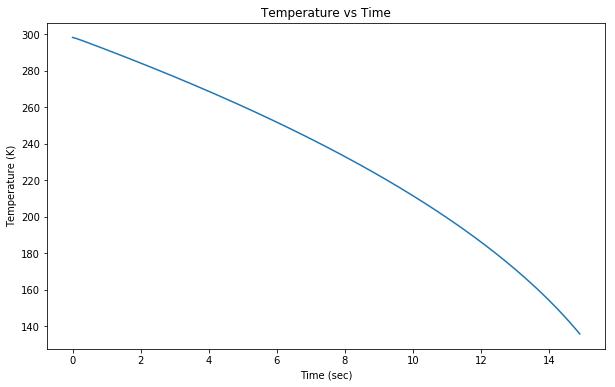

In [45]:
def tank_sim(t_i, tank_volume, prop_mass, mass_flow, dt):
        
    tank_time = 0.0
    
    tank_t_i = tank_t_f = t_i
    
    tank_p_i = tank_p_f = ((prop_mass/molar_mass)*R*(tank_t_i))/tank_volume
    
    time, tank_p, tank_t = [0],[tank_p_f],[tank_t_f]
    
    while tank_p_f >= p_reg_min:
        tank_p_i = tank_p_f
        tank_t_i = tank_t_f
        prop_mass = prop_mass - (mass_flow*dt)
        tank_time = tank_time + dt
        
        tank_p_f = ((prop_mass/molar_mass)*R*tank_t_f)/tank_volume
        tank_t_f = tank_t_i/((tank_p_i/tank_p_f)**((gamma-1)/gamma))
        
        time.append(tank_time)
        tank_p.append(tank_p_f)
        tank_t.append(tank_t_f)
        
    return time, tank_p, tank_t

time, tank_p, tank_t = tank_sim(t_o, tank_volume, prop_mass, mass_flow, 0.1)

plt.figure(5,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure vs Time')
plt.plot(time, tank_p)
plt.show()

plt.figure(6,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs Time')
plt.plot(time, tank_t)
plt.show()

<b>Step 9: Recalculate Vehicle and Engine Parameters</b>

Now that we've modeled our tank, we can combine it with our engine model to create a complete vehicle model: 


<img src="vehicle_model.png" style="max-width:100%; width: 50%">


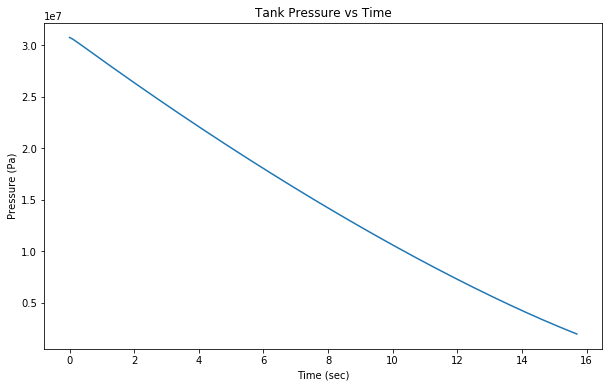

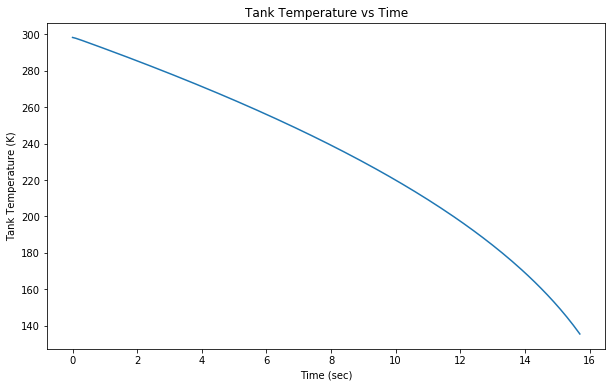

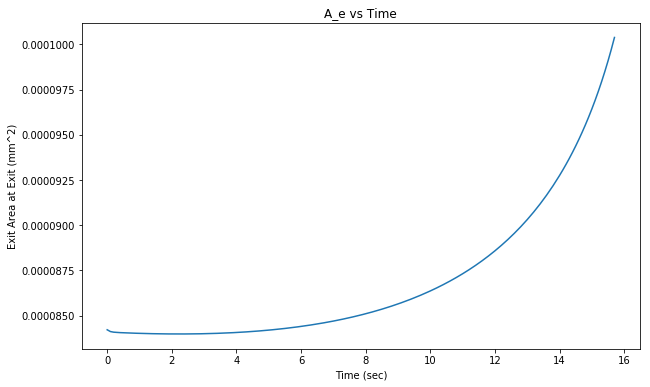

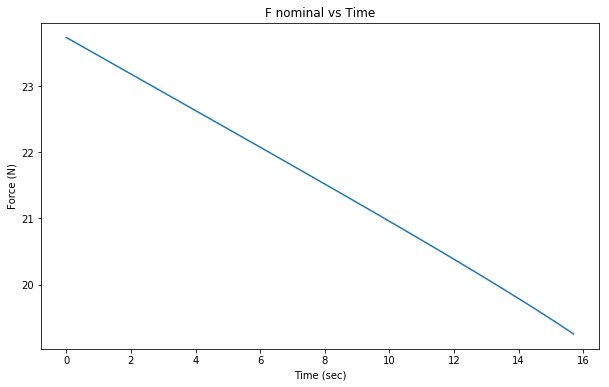

In [48]:
def vehicle_sim(molar_mass, prop_mass_init, tank_t_init, tank_v, dt):   
    
    # Initialize Tank
    tank_pressure = calc_tank_pressure(prop_mass_init, molar_mass, tank_t_init, tank_v)
    tank_volume = tank_v
    tank_prop_mass = prop_mass_init
    tank_temp = tank_t_init
    
    #Initialize Engine
    engine_p_o = p_chamber
    engine_t_o = tank_temp
    
    # Calculate Initial Engine State
    ma_e = calc_mach(engine_p_o, p_b, gamma)
    t_b = calc_t_b(engine_t_o, ma_e, gamma)
    v_e = calc_v_e(engine_p_o, p_b, t_b, molar_mass, gamma)
    isp = calc_isp(v_e)
    wet_mass = dry_mass + tank_prop_mass
    f_nom = calc_f_nom(wet_mass)
    mass_flow = calc_mass_flow(f_nom, v_e)
    a_e = calc_area_exit(p_o, t_o, ma_e, mass_flow, molar_mass, gamma)
    t_flight = calc_time_of_flight(tank_prop_mass, mass_flow)  
    
    # Simulation Initialization
    time = 0
    sim_time, sim_tank_p, sim_tank_t, sim_f_nom, sim_a_e, sim_ma_e = [time], \
                                                           [tank_pressure], \
                                                           [tank_temp], \
                                                           [f_nom], \
                                                           [a_e], \
                                                           [ma_e]
    # Simulation Loop
    while tank_pressure >= p_reg_min:
        # Calculate Tank State
        tank_p_i = tank_pressure
        tank_t_i = tank_temp
        tank_prop_mass = tank_prop_mass - (mass_flow*dt)
        time = time + dt
        
        tank_pressure = ((tank_prop_mass/molar_mass)*R*tank_temp)/tank_volume
        tank_temp = tank_t_i/((tank_p_i/tank_pressure)**((gamma-1)/gamma))
        
        sim_time.append(time)
        sim_tank_p.append(tank_pressure)
        sim_tank_t.append(tank_temp)
        
        # Calculate Engine State
        engine_t_o = tank_t_i
        
        ma_e = calc_mach(engine_p_o, p_b, gamma)
        t_b = calc_t_b(engine_t_o, ma_e, gamma)
        v_e = calc_v_e(engine_p_o, p_b, t_b, molar_mass, gamma)
        isp = calc_isp(v_e)
        wet_mass = dry_mass + tank_prop_mass
        f_nom = calc_f_nom(wet_mass)
        mass_flow = calc_mass_flow(f_nom, v_e)
        a_e = calc_area_exit(p_o, t_o, ma_e, mass_flow, molar_mass, gamma)
        t_flight = calc_time_of_flight(tank_prop_mass, mass_flow)   
        
        sim_f_nom.append(f_nom)
        sim_a_e.append(a_e)
        sim_ma_e.append(ma_e)
        
    return sim_time, sim_tank_p, sim_tank_t, sim_f_nom, sim_a_e, sim_ma_e

time, tank_p, tank_t, f_nom, a_e, ma_e = vehicle_sim(molar_mass, prop_mass, t_o, tank_volume, 0.1)

plt.figure(7,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Pressure (Pa)')
plt.title('Tank Pressure vs Time')
plt.plot(time, tank_p)
plt.show()

plt.figure(8,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Tank Temperature (K)')
plt.title('Tank Temperature vs Time')
plt.plot(time, tank_t)
plt.show()

plt.figure(9,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Exit Area at Exit (mm^2)')
plt.title('A_e vs Time')
plt.plot(time, a_e)
plt.show()

plt.figure(10,figsize=(10,6))
plt.xlabel('Time (sec)')
plt.ylabel('Force (N)')
plt.title('F nominal vs Time')
plt.plot(time, f_nom)
plt.show()

Finally, we print out all the new vehicle parameters:

In [47]:
# Print out final parameters
print ("Nominal Chamber Pressure: %.2f Pa\n" % p_o)
print ("Exit Mach Number: %.2f\n" % ma_e[0])
print ("Time of Flight: %0.2f sec\n" % time[len(time)-1])
print ("A_e: %.2f mm^2" % (a_e[0]*1e6))
print ("Exit Diameter: %.2f mm\n" % (2*(np.sqrt((a_e[0]*1e6)/np.pi))) )
print ("A_t: %.2f mm^2" % (a_t*1e6))
print ("Throat Diameter: %.2f mm \n" % (2*(np.sqrt((a_t*1e6)/np.pi))) )
print ("Ae/At Ratio: %0.2f" % a_e_a_t)

Nominal Chamber Pressure: 191784.01 Pa

Exit Mach Number: 1.70

Time of Flight: 15.70 sec

A_e: 84.21 mm^2
Exit Diameter: 10.35 mm

A_t: 24.15 mm^2
Throat Diameter: 5.54 mm 

Ae/At Ratio: 1.34


<b> Analysis: </b>
We observe a 3 second loss in our time of flight due to cooling (Joule-Thompson Effect) within the propellant tank. 

To compensate for temperature losses and to maximize the exit velocity, one could heat the engines chamber using a filament or heating pad and a battery. These options will be explored in a later notebook.

#### Sources and Citation: 

Sutton, George P., and Oscar Biblarz. Rocket Propulsion Elements. New York: John Wiley & Sons, 2010. Print.

Ãengel, Yunus A., and Michael A. Boles. Thermodynamics: An Engineering Approach. New York: McGraw-Hill Education, 2015. Print.